In [1]:
!pwd

/Users/yuanshi/Library/CloudStorage/Box-Box/Sequence Analysis/2025/D1D2_organize/script_DNA


In [2]:
import pandas as pd
import hashlib
import json,os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [3]:
#check md5 and store
def get_file_md5(file_path):
    md5_hash = hashlib.md5()
    with open(file_path, "rb") as file:
        for chunk in iter(lambda: file.read(4096), b""):
            md5_hash.update(chunk)
    return md5_hash.hexdigest()

def store_md5_in_json(file_paths, json_output):
    md5_dict = {}
    for file_path in file_paths:
        md5_hash = get_file_md5(file_path)
        md5_dict[file_path] = md5_hash

    with open(json_output, "w") as json_file:
        json.dump(md5_dict, json_file, indent=4)

In [4]:
#load from previous session
with open('../picklefiles/notebook2.pkl','rb') as f:
    info = pickle.load(f)

print (info.keys())

dict_keys(['reffile', 'summary', 'SampleIDs', 'provirus_types', 'thredict'])


# Generate perBC and perIS object

In [5]:
with open('../picklefiles/fdata.pkl','rb') as f:
    data = pickle.load(f)

In [6]:
len(data)

117

In [7]:
# generate perIS

In [8]:
summary = info['summary']
SampleIDs = info['SampleIDs']

In [9]:
summary.columns

Index(['SampleID', 'Mouse_Cohort', 'MouseID', 'Organ', 'Treatment', 'Depth',
       'HIV fraction', 'hg38 fraction', 'plasmid fraction',
       'unintegrated fraction', 'HIV_UMI_count', 'hg38_UMI_count',
       'plasmid_UMI_count', 'unintegrated_UMI_count'],
      dtype='object')

## A few sanitation steps
1. generate correct AnimalID
2. standalize  treatment into category

In [10]:
summary.loc[:,'AnimalID'] = summary.apply(lambda x: '{}-{}'.format(x['Mouse_Cohort'],x['MouseID']),axis=1)

In [11]:
def convert_treatment(entry):
    if entry == "DMSO" or entry == "No NK":
        return "No NK"
    elif entry == "GFP-NK":
        return "GFP-NK"
    elif entry == "D1D2-NK":
        return "D1D2-NK"

In [12]:
summary.loc[:,'Treatment']=summary['Treatment'].apply(lambda x: convert_treatment(x))
treatment_order = ['No NK', 'GFP-NK', 'D1D2-NK']
summary['Treatment'] = pd.Categorical(summary['Treatment'], categories=treatment_order, ordered=True)

In [13]:
fields = ['SampleID', 'Mouse_Cohort', 'MouseID','AnimalID', 'Organ', 'Treatment']

In [14]:
perSite = []
for _,entry in summary.iterrows():
    sampleID = entry['SampleID']
    tdata = data[sampleID]
    tdata = tdata[tdata['provirus type']=='hg38']
    tdata = tdata.groupby(['barcode','site']).count()[['UMI']].reset_index()
    for field in fields:
        tdata[field] = entry[field]
    perSite.append(tdata)
perIS = pd.concat(perSite)

In [15]:
perIS

,barcode,site,UMI,SampleID,Mouse_Cohort,MouseID,AnimalID,Organ,Treatment
0,GAGGGCGAAGCCGAGGTAGAC,chr16:1776110:-,2,JCMMG32-#44-LIV,JCMMG32,#44,JCMMG32-#44,LIV,D1D2-NK
1,GAGGGCGAAGCCGAGGTAGAT,chr16:1776110:-,136,JCMMG32-#44-LIV,JCMMG32,#44,JCMMG32-#44,LIV,D1D2-NK
2,GAGGGCGAAGCCGAGGTAGCT,chr16:1776110:-,2,JCMMG32-#44-LIV,JCMMG32,#44,JCMMG32-#44,LIV,D1D2-NK
3,GAGGGCGAAGGGGTAGGAGAC,chr16:1776110:-,6,JCMMG32-#44-LIV,JCMMG32,#44,JCMMG32-#44,LIV,D1D2-NK
4,GAGGGCGCAGCCGAGGTAGAT,chr16:1776110:-,3,JCMMG32-#44-LIV,JCMMG32,#44,JCMMG32-#44,LIV,D1D2-NK
...,...,...,...,...,...,...,...,...,...
285,TGAACTGATGCTGAGGGCGGT,chr6_GL000254v2_alt:4110861:+,1,JMGA36-#8-LIV,JMGA36,#8,JMGA36-#8,LIV,No NK
286,TGAGCTGATGCTGAGGCCGGT,chr12:64615399:+,1,JMGA36-#8-LIV,JMGA36,#8,JMGA36-#8,LIV,No NK
287,TGAGCTGATGCTGAGGGCGGT,chr12:64615399:+,1,JMGA36-#8-LIV,JMGA36,#8,JMGA36-#8,LIV,No NK
288,TGCGGAGTAGGTGAAGGGGTA,chr13:74057868:+,1,JMGA36-#8-LIV,JMGA36,#8,JMGA36-#8,LIV,No NK


In [16]:
perIS = perIS[perIS['barcode'].apply(lambda x: 'N' not in x)]

In [17]:
def get_RC(arr):
    arr = arr.upper()
    matching = {'A':'T','T':'A','G':'C','C':'G'}
    result = ''.join([matching[i] for i in arr])
    return result[::-1]
perIS.loc[:, 'barcode'] = perIS['barcode'].apply(get_RC)

In [18]:
perBC = pd.merge(perIS.groupby(fields+['barcode']).sum()[['UMI']],perIS.groupby(fields+['barcode']).count()[['site']],left_index=True,right_index=True).reset_index()

In [19]:
print ('Total integration site information recovered:',len(perIS))
print ('Total barcode information recovered:',len(perBC))

print ('Unique integration sites:', len(perIS['site'].unique()))
print ('Unique barcodes:', len(perBC['barcode'].unique()))

Total integration site information recovered: 25854
Total barcode information recovered: 8495
Unique integration sites: 7926
Unique barcodes: 4142


# Another cleanup step

## assign site to dominant barcode

In [20]:
df = perIS[['site','barcode','UMI']].copy()
df = df.loc[df.groupby('site')['UMI'].idxmax()].reset_index(drop=True)[['site','barcode']]

In [21]:
site_bc_dict = df.set_index('site').to_dict()

In [22]:
site_bc_dict.keys()

dict_keys(['barcode'])

In [23]:
perIS = perIS.groupby(['site','SampleID','Mouse_Cohort','MouseID','AnimalID','Organ','Treatment']).sum()[['UMI']].reset_index()

In [24]:
perIS['barcode'] = perIS['site'].apply(lambda x:site_bc_dict['barcode'][x])

## assign bc to dominant animal

In [25]:
df = perBC[['barcode','UMI','AnimalID']].copy()
df = df.loc[df.groupby('barcode')['UMI'].idxmax()].reset_index(drop=True)[['barcode','AnimalID']]

In [26]:
animal_bc_dict = df.set_index('barcode').to_dict()

In [27]:
animal_bc_dict.keys()

dict_keys(['AnimalID'])

In [28]:
mask = perIS.apply(lambda row: animal_bc_dict['AnimalID'].get(row['barcode']) == row['AnimalID'], axis=1)
perIS = perIS[mask].reset_index(drop=True)

In [29]:
perBC = pd.merge(perIS.groupby(fields+['barcode']).sum()[['UMI']],perIS.groupby(fields+['barcode']).count()[['site']],left_index=True,right_index=True).reset_index()

In [30]:

print ("After cleaning up:")
print ('Total integration site information recovered:',len(perIS))
print ('Total barcode information recovered:',len(perBC))

print ('Unique integration sites:', len(perIS['site'].unique()))
print ('Unique barcodes:', len(perBC['barcode'].unique()))

After cleaning up:
Total integration site information recovered: 7275
Total barcode information recovered: 1059
Unique integration sites: 7107
Unique barcodes: 908


# Proliferation Information

In [31]:
# Proliferation is defined as more than UMI recovered for that site in that *animal* (not tissue sample)
prolif_dict = perIS.groupby(['site','AnimalID']).count()[['UMI']].to_dict()

In [32]:
perIS.loc[:,'Proliferation'] = perIS.apply(lambda x: prolif_dict['UMI'][(x['site'],x['AnimalID'])]>1,axis=1)

# Retrieve viremia information

In [33]:
with open('../script_RNA/adata.pickle','rb') as f:
    RNAs = pickle.load(f)

In [34]:
Summary_RNA=pd.read_csv('../script_RNA/summary_D1D2RNA_052525.csv')

Text(0.5, 1.0, 'SampleID Overlap')

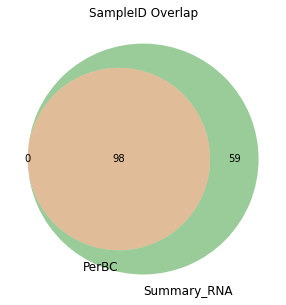

In [35]:
plt.figure(figsize=(5, 5))
venn = venn2([set(perBC['SampleID']), set(Summary_RNA['SampleID'])], ('PerBC', 'Summary_RNA'))
plt.title('SampleID Overlap')

Text(0.5, 1.0, 'AnimalID Overlap')

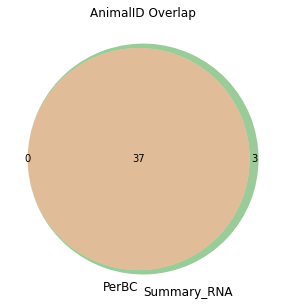

In [36]:
plt.figure(figsize=(5, 5))
venn = venn2([set(perBC['AnimalID']), set(Summary_RNA['AnimalID'])], ('PerBC', 'Summary_RNA'))
plt.title('AnimalID Overlap')

Generate RNA_lib as a dictionary, key is sampleID, value is 
1) each barcode transcription level in that sample;
2) averaged barcode transcription level in that animal;
3) each barcode transcription level in the TB of that animal

## Tissue level transcription level

In [37]:
len(Summary_RNA)

157

In [38]:
#sample level RNA lib

RNAseqlib_dict = Summary_RNA.set_index(['SampleID'])['SeqLibraryID'].to_dict()

RNA_lib = dict() 

for sampleID in SampleIDs:
    tdata = RNAs[RNAseqlib_dict[sampleID]].copy()
    tdata['freq'] = tdata['count']/np.sum(tdata['count'])
    RNA_lib[sampleID] = tdata.set_index('cluster').to_dict()['freq']

perIS.loc[:,'Transcription_Organ'] = perIS.apply(lambda x:RNA_lib[x['SampleID']].get(x['barcode'],0),axis=1)

In [39]:
perIS[perIS['Transcription_Organ']>0].groupby(['Treatment']).count()[['Transcription_Organ']]

,Transcription_Organ
Treatment,
D1D2-NK,807
GFP-NK,2797
No NK,604


## Animal Level Transcription

In [40]:
Summary_RNA['Organ'].unique()

array(['SP', 'BM', 'TB', 'LIV'], dtype=object)

In [41]:
df = Summary_RNA[Summary_RNA['Organ']!='TB'] #exlude TB here
len(df)

117

In [42]:
RNAseqlib_dict = df.groupby('AnimalID').agg(list)[['SeqLibraryID']].to_dict()

In [43]:
AnimalIDs = list(summary['AnimalID'].unique())
len(AnimalIDs)

40

In [44]:
#animal level RNA lib, average transcription
RNA_lib = dict()

for animalID in AnimalIDs:
    all_organs = []
    for LibSeqID in RNAseqlib_dict['SeqLibraryID'][animalID]:
        tdata = tdata = RNAs[LibSeqID].copy() 
        tdata['freq'] = tdata['count']/np.sum(tdata['count'])
        all_organs.append(tdata[['cluster','freq']])
    merged = all_organs[0]
    for all_organ in all_organs[1:]:
        merged = pd.merge(merged,all_organ,left_on='cluster',right_on='cluster',how='outer').replace(np.nan,0)
    merged = merged.set_index('cluster')
    merged['averaged freq'] = merged.mean(axis=1)
    RNA_lib[animalID] = merged.to_dict()['averaged freq']

perIS.loc[:,'Transcription_Animal'] = perIS.apply(lambda x:RNA_lib[x['AnimalID']].get(x['barcode'],0),axis=1)

In [45]:
perIS[perIS['Transcription_Animal']>0].groupby(['Treatment']).count()[['Transcription_Organ']]

,Transcription_Organ
Treatment,
D1D2-NK,807
GFP-NK,2813
No NK,722


## Transcription in TB

In [46]:
len(Summary_RNA[Summary_RNA['Organ']=='TB'])

40

In [47]:
#key is sampleID, value is the SeqLibraryID of TB 

In [48]:
tdata

,cluster,count,freq
0,ACCGCCCTCAGCATCAGCTCC,18725,0.697887
1,TCCATCAGCTCCCACGACGAC,2648,0.098692
2,TACCCCTTCACCTACTCCGCC,1940,0.072304
3,GGCTGCGACGGCCTCGTCGCC,860,0.032052
4,ATCTGCTACAGCTTCCTCTCC,509,0.018971
5,AGCTTCTCCTTCAACGACGGC,273,0.010175
6,GTCAACTTCTTCTCCTTCACC,263,0.009802
7,AGCTTCGTCGTCCTCAACATC,212,0.007901
8,TGCGTCACCTTCAGCAGCGTC,182,0.006783
9,CACTACACCATCCTCTCCGTC,107,0.003988


In [49]:
RNAseqlib_dict = dict()
for sampleID in SampleIDs:
    animalID = Summary_RNA[Summary_RNA['SampleID'] == sampleID]['AnimalID'].unique()
    assert len(animalID) == 1
    mask1 = Summary_RNA['AnimalID'] == animalID[0]
    mask2 = Summary_RNA['Organ'] == 'TB'
    tdata = Summary_RNA[mask1 & mask2]
    assert len(tdata) == 1
    RNAseqlib_dict[sampleID] = tdata.iloc[0]['SeqLibraryID']

In [50]:
RNA_lib = dict() 

for sampleID in SampleIDs:
    tdata = RNAs[RNAseqlib_dict[sampleID]].copy()
    tdata['freq'] = tdata['count']/np.sum(tdata['count'])
    RNA_lib[sampleID] = tdata.set_index('cluster').to_dict()['freq']

perIS.loc[:,'Transcription_TB'] = perIS.apply(lambda x:RNA_lib[x['SampleID']].get(x['barcode'],0),axis=1)

In [51]:
perIS[perIS['Transcription_TB']>0].groupby(['Treatment']).count()[['Transcription_Organ']]

,Transcription_Organ
Treatment,
D1D2-NK,786
GFP-NK,2772
No NK,542


In [52]:
perIS['Viremia'] = perIS['Transcription_TB']>0

In [53]:
perIS.groupby(['Treatment','Proliferation','Viremia']).count()[['UMI']]

UMI
Treatment Proliferation Viremia      
D1D2-NK   False         False     717
                        True      776
          True          False      14
                        True       10
GFP-NK    False         False     788
                        True     2695
          True          False      41
                        True       77
No NK     False         False    1543
                        True      438
          True          False      72
                        True      104

In [54]:
# QC double check if the Viremia make sense

In [55]:
RNA_lib1 = dict()
for _,entry in Summary_RNA.iterrows():
    RNA_lib1[entry['SampleID']]=RNAs[entry['SeqLibraryID']]
def check_viremia(entry):
    BC = entry['barcode']
    SampleID = entry['SampleID']
    RNAs = set(RNA_lib1[SampleID]['cluster'])
    return BC in RNAs

In [56]:
perBC['Transcription_Organ'] = perBC.apply(lambda x: check_viremia(x), axis=1)

In [57]:
from collections import defaultdict
RNA_lib2 = defaultdict(list)
df = Summary_RNA[Summary_RNA['Organ']!='TB']
for _,entry in df.iterrows():
    RNA_lib2[entry['AnimalID']].append(RNAs[entry['SeqLibraryID']])

def check_viremia2(entry):
    BC = entry['barcode']
    SampleID = entry['AnimalID']
    RNAs = set()
    for df in RNA_lib2[SampleID]:
        RNAs.update(set(df['cluster']))
    return BC in RNAs

In [58]:
perBC['Transcription_Animal'] = perBC.apply(lambda x: check_viremia2(x), axis=1)

In [59]:
RNA_lib3 = dict()
for _,entry in Summary_RNA.iterrows():
    if entry['Organ'] == 'TB':
        RNA_lib3[entry['AnimalID']] = RNAs[entry['SeqLibraryID']]

def check_viremia3(entry):
    BC = entry['barcode']
    SampleID = entry['AnimalID']
    RNAs = set(RNA_lib3[SampleID]['cluster'])
    return BC in RNAs

In [60]:
perBC['Viremia'] = perBC.apply(lambda x: check_viremia3(x), axis=1)

In [61]:
# check transcription_organ
check_dict = perBC.set_index(['SampleID','barcode'])['Transcription_Organ'].to_dict()
for _,entry in perIS.iterrows():
    if check_dict[(entry['SampleID'],entry['barcode'])]:
        if entry['Transcription_Organ'] == 0:
            print ('problem found, has transcription in organ, but label as no transcription_organ in BC data:',entry['SampleID'],entry['barcode'])
    if not check_dict[(entry['SampleID'],entry['barcode'])]:
        if entry['Transcription_Organ'] > 0:
            print ('problem found, has no transcription in organ, but label as transcription_organ in BC data:',entry['SampleID'],entry['barcode'])

In [62]:
# check transcription_animal
check_dict = perBC.set_index(['SampleID','barcode'])['Transcription_Animal'].to_dict()
for _,entry in perIS.iterrows():
    if check_dict[(entry['SampleID'],entry['barcode'])]:
        if entry['Transcription_Animal'] == 0:
            print ('problem found, has transcription in organ, but label as no transcription_organ in BC data:',entry['SampleID'],entry['barcode'])
    if not check_dict[(entry['SampleID'],entry['barcode'])]:
        if entry['Transcription_Animal'] > 0:
            print ('problem found, has no transcription in organ, but label as transcription_organ in BC data:',entry['SampleID'],entry['barcode'])

In [63]:
# check transcription_TB
check_dict = perBC.set_index(['SampleID','barcode'])['Viremia'].to_dict()
for _,entry in perIS.iterrows():
    if check_dict[(entry['SampleID'],entry['barcode'])]:
        if entry['Transcription_TB'] == 0:
            print ('problem found, has transcription in organ, but label as no transcription_organ in BC data:',entry['SampleID'],entry['barcode'])
    if not check_dict[(entry['SampleID'],entry['barcode'])]:
        if entry['Transcription_TB'] > 0:
            print ('problem found, has no transcription in organ, but label as transcription_organ in BC data:',entry['SampleID'],entry['barcode'])

In [64]:
#All good!

In [65]:
perBC.columns

Index(['SampleID', 'Mouse_Cohort', 'MouseID', 'AnimalID', 'Organ', 'Treatment',
       'barcode', 'UMI', 'site', 'Transcription_Organ', 'Transcription_Animal',
       'Viremia'],
      dtype='object')

In [66]:
perIS.columns

Index(['site', 'SampleID', 'Mouse_Cohort', 'MouseID', 'AnimalID', 'Organ',
       'Treatment', 'UMI', 'barcode', 'Proliferation', 'Transcription_Organ',
       'Transcription_Animal', 'Transcription_TB', 'Viremia'],
      dtype='object')

# Save data

In [68]:
summary

,SampleID,Mouse_Cohort,MouseID,Organ,Treatment,Depth,HIV fraction,hg38 fraction,plasmid fraction,unintegrated fraction,HIV_UMI_count,hg38_UMI_count,plasmid_UMI_count,unintegrated_UMI_count,AnimalID
0,JCMMG32-#44-LIV,JCMMG32,#44,LIV,D1D2-NK,209192,0.000364,0.023251,0.000000,0.976384,2,301,0,0,JCMMG32-#44
1,JCMMG32-#44-SP,JCMMG32,#44,SP,D1D2-NK,777659,0.000687,0.015803,0.000280,0.983229,41,1250,0,0,JCMMG32-#44
2,JCMMG32-#44-BM,JCMMG32,#44,BM,D1D2-NK,2820269,0.002521,0.028942,0.002393,0.966144,434,5835,0,0,JCMMG32-#44
6,JCMMG32-#58-SP,JCMMG32,#58,SP,D1D2-NK,1709173,0.004678,0.008498,0.000131,0.986692,668,1083,0,0,JCMMG32-#58
7,JCMMG32-#58-LIV,JCMMG32,#58,LIV,D1D2-NK,41991,0.003332,0.006910,0.000070,0.989688,4,42,0,0,JCMMG32-#58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,JMGA36-#6-SP,JMGA36,#6,SP,No NK,289363,0.001132,0.021018,0.000000,0.977850,34,503,0,0,JMGA36-#6
241,JMGA36-#6-LIV,JMGA36,#6,LIV,No NK,407225,0.011635,0.055448,0.000268,0.932649,112,574,0,0,JMGA36-#6
242,JMGA36-#8-BM,JMGA36,#8,BM,No NK,286031,0.002029,0.018500,0.000164,0.979306,24,469,0,0,JMGA36-#8
243,JMGA36-#8-SP,JMGA36,#8,SP,No NK,395308,0.000498,0.024244,0.000008,0.975250,21,744,0,0,JMGA36-#8


In [69]:
perIS.to_csv('../csvfiles/perIS_lite.csv',index=False)
perBC.to_csv('../csvfiles/perBC_lite.csv',index=False)
summary.to_csv('../csvfiles/summary_lite.csv',index=False)

In [70]:
paths = ('../csvfiles/perIS_lite.csv','../csvfiles/perBC_lite.csv','../csvfiles/summary_lite.csv')
store_md5_in_json(paths,'../jsonfiles/notebook3_output.json')

In [71]:
!cat ../jsonfiles/notebook3_output.json

{
    "../csvfiles/perIS_lite.csv": "f8ec531a9be85b21fda41705eaa12fa5",
    "../csvfiles/perBC_lite.csv": "4697f81aadebcf82aa824628529afd3e",
    "../csvfiles/summary_lite.csv": "98d0cc77b16c71acef959692a594d393"
}